<a href="https://colab.research.google.com/github/jceltruda/CNN-for-Lung-Cancer-Classification/blob/main/CNN_for_Lung_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
import os
from datasets import load_dataset
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import ImageOps
import matplotlib.pyplot as plt

Load and save dataset:

In [ ]:
# Loading dataset from Hugging Face and saving to Google Drive
drive.mount('/content/drive')

"""
ds = load_dataset("dorsar/lung-cancer")


for data_type in ds:
  count = 0

  for item in ds[data_type]:

    label = str(item['label'])
    if data_type == 'test':
      if label == '0':
        label = '1'
      elif label == '5':
        label = '6'
      elif label == '2':
        label = '3'

    path = f'/content/drive/MyDrive/path/{data_type}/{label}/'

    if not os.path.exists(path):
      os.makedirs(path)

    item['image'].save(path + f'image_{count}.png')
    count += 1
    #"""

Visualize sample data point:

Label: 1


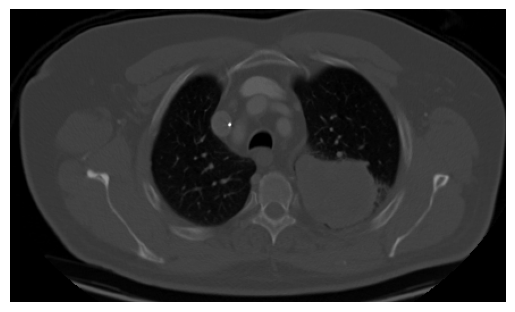

Label: 0


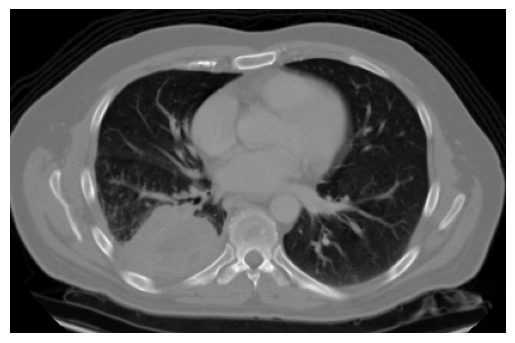

In [ ]:
# Load dataset
train_data = ImageFolder('/content/drive/MyDrive/path/')

# Get two data points
image, label = train_data[100]
image_2, label_2 = train_data[50]

# Print sample labels and images
print(f'Label: {label}')
plt.imshow(image)
plt.axis('off')
plt.show()

print(f'Label: {label_2}')
plt.imshow(image_2)
plt.axis('off')
plt.show()

In [ ]:
# Define our custom transform
transform = transforms.Compose([
    transforms.Resize((256, 400)), # Resizes
    transforms.Grayscale(num_output_channels=1), # Converts to grayscale
    transforms.ColorJitter(contrast=2.0), # Enhances contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
train_data = ImageFolder('/content/drive/MyDrive/path/', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

class LungCancerCNN(nn.Module):
    def __init__(self):
        super(LungCancerCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flat_features = 32 * 62 * 98

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_features, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)
"""
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LungCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(49):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Loss: {epoch_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/path/model_name.pth')
#"""


Testing Accuracy:

In [ ]:
path = f'/content/drive/MyDrive/path/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

# Load the trained model
model = LungCancerCNN()
model.load_state_dict(torch.load(os.path.join(path, 'model_name.pth'), map_location=device, weights_only=True))
model = model.to(device)
model.eval()

# Load test dataset and apply transformations
test_dataset = ImageFolder(os.path.join(path, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size 1 for single image predictions

# Dictionary to store predictions per class
predictions = {0: [], 1: [], 2: [], 3: []}

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)

    # Get the predicted class
    predicted_class = torch.argmax(outputs, dim=1).item()
    predictions[labels.item()].append(predicted_class)

# For recording model classifications
correct_predictions = 0
total_predictions = 0
false_negatives = 0
positive_samples = 0

for i in range (4):
  for j in range (4):
    j_predictions = predictions[i].count(j)
    mapping = {0: 1, 1: 3, 2: 4, 3: 6} # Maps index i or j to the correct class in our data
    x = mapping[i]
    y = mapping[j]
    print(f'class {x} classified as {y}: {round(j_predictions/ len(predictions[i]) * 100, 3)}%')
    if i == j:
      correct_predictions += j_predictions
    total_predictions += j_predictions
    # If class is cancerous
    if i in [0, 1, 3]:
      false_negatives += predictions[i].count(2) # Count of predictions classified as non-cancerous
      positive_samples += len(predictions[i])
  print()

# Print results
false_positives = len(predictions[2]) - predictions[2].count(2)
print(f'False negatives: {round(false_negatives / positive_samples * 100, 3)}%')
print(f'False positives: {round(false_positives / len(predictions[2]) * 100, 3)}%')
print()
print(f'Accuracy: {round(correct_predictions / total_predictions * 100, 3)}%')
print('Class labels: 1 = adenocarcinoma, 3 = large cell carcinoma, 4 = normal, 6 = squamous cell carcinoma')
print()
print(f'Cancerous vs Non Cancerous overall error: {round((false_positives + false_negatives) / total_predictions * 100, 3)}%')

class 1 classified as 1: 20.0%
class 1 classified as 3: 13.0%
class 1 classified as 4: 0.0%
class 1 classified as 6: 67.0%

class 3 classified as 1: 15.686%
class 3 classified as 3: 23.529%
class 3 classified as 4: 0.0%
class 3 classified as 6: 60.784%

class 4 classified as 1: 3.704%
class 4 classified as 3: 0.0%
class 4 classified as 4: 90.741%
class 4 classified as 6: 5.556%

class 6 classified as 1: 6.667%
class 6 classified as 3: 10.0%
class 6 classified as 4: 0.0%
class 6 classified as 6: 83.333%

False negatives: 0.0%
False positives: 9.259%

Accuracy: 52.881%
Class labels: 1 = adenocarcinoma, 3 = large cell carcinoma, 4 = normal, 6 = squamous cell carcinoma

Cancerous vs Non Cancerous overall error: 1.695%
